In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
from ipaddress import ip_address, IPv4Address, IPv4Network
import ipaddress

fablib = fablib_manager()

fablib.show_config();

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Token File,/home/fabric/.tokens.json
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
Bastion Username,hmolson4_0000155643
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Bastion Host,bastion.fabric-testbed.net
Bastion Private Key Passphrase,None
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Private Key Passphrase,None


In [2]:
#slice configurations
slice_name = 'ProjectSlice'

client_name = 'Client'
graphics_name = 'Graphics'
logic1_name = 'Logic1'
logic2_name = 'Logic2'
logic3_name = 'Logic3'

client_site = graphics_site = logic1_site = 'LOSA' #same site to simulate edge
logic2_site = 'DALL'
logic3_site = 'ATLA'

network1_name = 'net1'
network2_name = 'net2'
network3_name = 'net3'

In [3]:
#set up slice

slice = fablib.new_slice(name=slice_name)

net1 = slice.add_l3network(name=network1_name, type='IPv4')
net2 = slice.add_l3network(name=network2_name, type='IPv4')
net3 = slice.add_l3network(name=network3_name, type='IPv4')

#Client Node
client_node = slice.add_node(name=client_name, site=client_site, image="default_ubuntu_20")
client_interface = client_node.add_component(model='NIC_Basic', name='nic1').get_interfaces()[0]
client_interface.set_mode('auto')
net1.add_interface(client_interface)
client_node.add_route(subnet=fablib.FABNETV4_SUBNET, next_hop=net1.get_gateway())

#Graphics Node
graphics_node = slice.add_node(name=graphics_name, site=graphics_site, image="default_ubuntu_20")
graphics_interface = graphics_node.add_component(model='NIC_Basic', name='nic1').get_interfaces()[0]
graphics_interface.set_mode('auto')
net1.add_interface(graphics_interface)
graphics_node.add_route(subnet=fablib.FABNETV4_SUBNET, next_hop=net1.get_gateway())

#Logic1 Node
logic1_node = slice.add_node(name=logic1_name, site=logic1_site, image="default_ubuntu_20")
logic1_interface = logic1_node.add_component(model='NIC_Basic', name='nic1').get_interfaces()[0]
logic1_interface.set_mode('auto')
net1.add_interface(logic1_interface)
logic1_node.add_route(subnet=fablib.FABNETV4_SUBNET, next_hop=net1.get_gateway())

#Logic2 Node
logic2_node = slice.add_node(name=logic2_name, site=logic2_site, image="default_ubuntu_20")
logic2_interface = logic2_node.add_component(model='NIC_Basic', name='nic1').get_interfaces()[0]
logic2_interface.set_mode('auto')
net2.add_interface(logic2_interface)
logic2_node.add_route(subnet=fablib.FABNETV4_SUBNET, next_hop=net2.get_gateway())

#Logic3 Node
logic3_node = slice.add_node(name=logic3_name, site=logic3_site, image="default_ubuntu_20")
logic3_interface = logic3_node.add_component(model='NIC_Basic', name='nic1').get_interfaces()[0]
logic3_interface.set_mode('auto')
net3.add_interface(logic3_interface)
logic3_node.add_route(subnet=fablib.FABNETV4_SUBNET, next_hop=net3.get_gateway())

slice.submit()


Retry: 11, Time: 355 sec


ID,e3df1e54-763e-4ddd-812d-cb6ff395d669
Name,ProjectSlice
Lease Expiration (UTC),2024-04-21 21:53:49 +0000
Lease Start (UTC),2024-04-20 21:53:50 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
c07a1ebc-c4b2-43e3-8a42-27bb0c4fb1e2,Client,2,8,10,default_ubuntu_20,qcow2,losa-w3.fabric-testbed.net,LOSA,ubuntu,2001:400:a100:3070:f816:3eff:fe66:b42,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fe66:b42,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
fded196e-12ef-46ec-93bc-69f5f47d82d5,Graphics,2,8,10,default_ubuntu_20,qcow2,losa-w3.fabric-testbed.net,LOSA,ubuntu,2001:400:a100:3070:f816:3eff:fe0a:f2f5,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fe0a:f2f5,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
c06723c6-3720-40b2-a757-a26fd47a45ea,Logic1,2,8,10,default_ubuntu_20,qcow2,losa-w3.fabric-testbed.net,LOSA,ubuntu,2001:400:a100:3070:f816:3eff:fecb:84e7,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fecb:84e7,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
638973c7-6186-4ea3-8997-b61fd850a52e,Logic2,2,8,10,default_ubuntu_20,qcow2,dall-w1.fabric-testbed.net,DALL,ubuntu,2001:400:a100:3000:f816:3eff:fef4:2e60,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fef4:2e60,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
6d2a16ce-fb2d-4f25-9b8e-ff44b6008c52,Logic3,2,8,10,default_ubuntu_20,qcow2,atla-w2.fabric-testbed.net,ATLA,ubuntu,2001:400:a100:3050:f816:3eff:fe32:8e09,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3050:f816:3eff:fe32:8e09,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
9432431d-6a54-4bed-b524-a20eb124e513,net1,L3,FABNetv4,LOSA,10.137.5.0/24,10.137.5.1,Active,
4665ae07-cb8e-4cba-a0b5-527939bb3c41,net2,L3,FABNetv4,DALL,10.133.130.0/24,10.133.130.1,Active,
c8b75965-f1af-46e9-a37c-27926ae1e5c6,net3,L3,FABNetv4,ATLA,10.138.134.0/24,10.138.134.1,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node
Client-nic1-p1,p1,Client,net1,100,auto,,06:44:34:D0:FF:B6,enp6s0,enp6s0,10.137.5.4,4
Graphics-nic1-p1,p1,Graphics,net1,100,auto,,06:8C:9E:8B:C0:2F,enp6s0,enp6s0,10.137.5.2,4
Logic1-nic1-p1,p1,Logic1,net1,100,auto,,4A:03:E2:BB:0D:A6,enp6s0,enp6s0,10.137.5.3,4
Logic2-nic1-p1,p1,Logic2,net2,100,auto,,5E:12:6E:84:A8:C6,enp7s0,enp7s0,10.133.130.2,6
Logic3-nic1-p1,p1,Logic3,net3,100,auto,,06:E1:DD:F8:93:3B,enp7s0,enp7s0,10.138.134.2,1



Time to print interfaces 355 seconds


'e3df1e54-763e-4ddd-812d-cb6ff395d669'

In [4]:
slice = fablib.get_slice(slice_name)

client_node = slice.get_node(client_name)
graphics_node = slice.get_node(graphics_name)
logic1_node = slice.get_node(logic1_name)
logic2_node = slice.get_node(logic2_name)
logic3_node = slice.get_node(logic3_name)


#test connections
nodes = [[client_node, client_node.get_interface(network_name=network1_name).get_ip_addr()],
         [graphics_node, graphics_node.get_interface(network_name=network1_name).get_ip_addr()],
         [logic1_node, logic1_node.get_interface(network_name=network1_name).get_ip_addr()],
         [logic2_node, logic2_node.get_interface(network_name=network2_name).get_ip_addr()],
         [logic3_node, logic3_node.get_interface(network_name=network3_name).get_ip_addr()],
        ]

print(nodes)

for i in range(0, len(nodes)-1):
    for j in range(i+1, len(nodes)):
        print(nodes[j][1])
        nodes[i][0].execute(f'ping -c 3 {nodes[j][1]}')

print('done')

[[<fabrictestbed_extensions.fablib.node.Node object at 0x7f9824345d80>, IPv4Address('10.137.5.4')], [<fabrictestbed_extensions.fablib.node.Node object at 0x7f98095e7280>, IPv4Address('10.137.5.2')], [<fabrictestbed_extensions.fablib.node.Node object at 0x7f9809639de0>, IPv4Address('10.137.5.3')], [<fabrictestbed_extensions.fablib.node.Node object at 0x7f9845211030>, IPv4Address('10.133.130.2')], [<fabrictestbed_extensions.fablib.node.Node object at 0x7f98095a59f0>, IPv4Address('10.138.134.2')]]
10.137.5.2
PING 10.137.5.2 (10.137.5.2) 56(84) bytes of data.
64 bytes from 10.137.5.2: icmp_seq=1 ttl=64 time=0.256 ms
64 bytes from 10.137.5.2: icmp_seq=2 ttl=64 time=0.769 ms
64 bytes from 10.137.5.2: icmp_seq=3 ttl=64 time=0.065 ms

--- 10.137.5.2 ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2030ms
rtt min/avg/max/mdev = 0.065/0.363/0.769/0.297 ms
10.137.5.3
PING 10.137.5.3 (10.137.5.3) 56(84) bytes of data.
64 bytes from 10.137.5.3: icmp_seq=1 ttl=64 time=0.17

In [5]:
#slice = fablib.get_slice(slice_name)
#slice.delete()

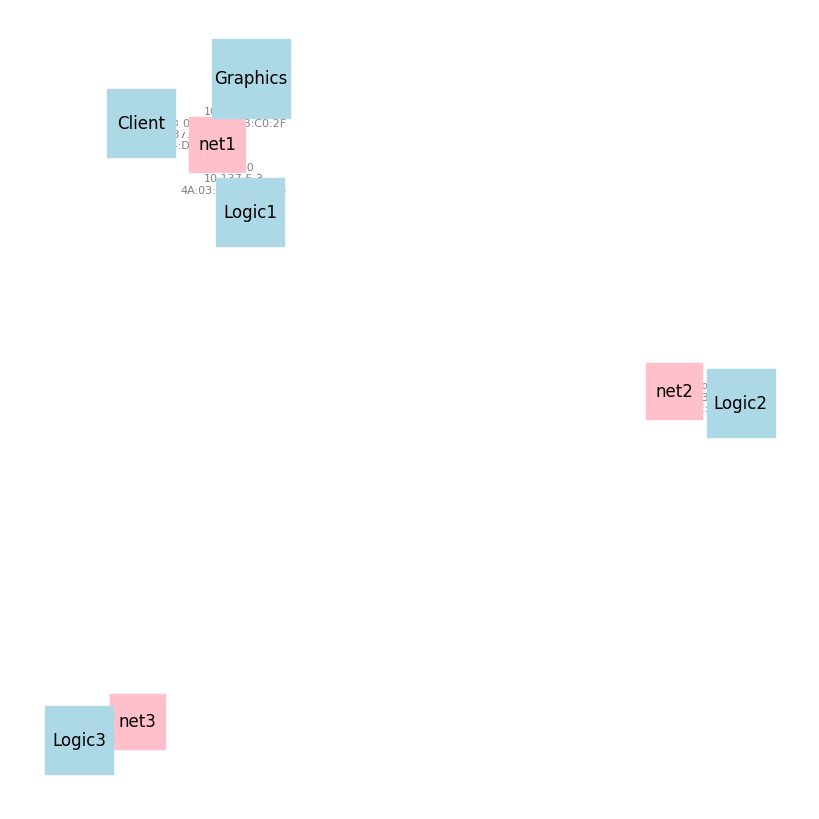

In [6]:
#draw network topology
import networkx as nx
import matplotlib.pyplot as plt

l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

In [7]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
Client,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fe66:b42
Graphics,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fe0a:f2f5
Logic1,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3070:f816:3eff:fecb:84e7
Logic2,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fef4:2e60
Logic3,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3050:f816:3eff:fe32:8e09


In [8]:
from datetime import datetime
from datetime import timezone
from datetime import timedelta

# Set end date to 3 days from now
end_date = (datetime.now(timezone.utc) + timedelta(days=7)).strftime("%Y-%m-%d %H:%M:%S %z")
slice.renew(end_date)